# Barcelona Airbnb 2021

## Section 1: Business Understanding

This project intends to evaluate the effect of the Covid19 pandemic on [Airbnb hosting prices](http://insideairbnb.com/get-the-data.html) in the city of Barcelona. We use the number of reviews as a metric for the number of tourists in the city and the number of positive cases for the prevalence of [Covid19](https://cnecovid.isciii.es/covid19/#documentaci%C3%B3n-y-datos) in the region of Catalonia.



### Question 1: What was the impact of the pandemic on Airbnb accommodation from the second outbreak onwards?
### Question 2: Which are the key success factors to attract guests in this situation?
### Question 3: How did price evolve in these ever-changing circumstances?


Sources: [Inside Airbnb](http://insideairbnb.com/get-the-data.html), [Covid19](https://cnecovid.isciii.es/covid19/#documentaci%C3%B3n-y-datos)


In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In /home/jorge/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/jorge/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/jorge/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/jorge/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/jorge/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

In [2]:
#Fetching data. From the Airbnb source, we create a dataset dictionary with an entry for each month
raw_df_dict = {'aug': pd.read_csv('./listings_aug20.csv'),
               'sep': pd.read_csv('./listings_sept20.csv'),
               'oct': pd.read_csv('./listings_oct20.csv'),
               'nov': pd.read_csv('./listings_nov20.csv'),
               'dec': pd.read_csv('./listings_dec20.csv'),
               'jan': pd.read_csv('./listings_jan21.csv'),
               'feb': pd.read_csv('./listings_feb21.csv'),
               'mar': pd.read_csv('./listings_mar21.csv'),
               'apr': pd.read_csv('./listings_apr21.csv')      
               }

months = raw_df_dict.keys()
for month in months:
    raw_df_dict[month].set_index('id')

# Data Exploration

For the data exploration, only one dataset will be used since all of them share the same columns and have similar number of entries. Therefore, all of them will be processed equally

In [3]:
# Columns of the datasets
raw_df_dict['aug'].columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

# Preprocessing Data

In [4]:
# Data from 'raw_df_dict' will be processed and stored in 'df_dict'
df_dict = {month: pd.DataFrame() for month in months}


# Most data are ready to use
for month in months:
    # Filter numerical features from the DataFrame
    numerical_columns = raw_df_dict[month].select_dtypes(include='number').columns
    # Drop non-relevant features
    numerical_columns = numerical_columns.drop(['scrape_id', 'host_id'])
    # Insert into the new DataFrame
    df_dict[month][numerical_columns] = raw_df_dict[month][numerical_columns]


## Format Fixing

In [5]:
def host_aceptance_rate_to_numeric(rate_string):
    """ Transforms the string type column 'host_acceptance_rate' into int type
    INPUT
        rate_string: string
            contains the string type column 'host_acceptance_rate' (format example '90%')
    OUTPUT
        rate_numeric: int
            contains the numeric value of 'host_acceptance_rate'
    """
    try:
        rate_numeric = int(rate_string[:-1])
    except:
        rate_numeric = np.nan
    return rate_numeric

In [6]:
def price_to_numeric(price):
    """ Transforms the string type column 'price' into int type
    Parameters
    ----------
    price : string
            contains the price (format example '$1,000.00')
    Returns
    -------
    price_numeric : int, NaN
                    returns the numeric value of 'price'. Returns NaN if price is not a string
    """
    try:
        price_numeric = int(price[1:-3].replace(',',''))
    except:
        price_numeric = np.nan
    return price_numeric

In [7]:
def string_to_date(date_string, date_format='%Y-%m-%d'):
    """" Converts string into datetime type
    Parameters
    ----------
    date_string: string
        contains the date
    date_format: string
        contains the format of the date
        
    Returns
    -------
    date : datetime, NaT
           contains the date. It is NaT if date_string is NaN
    """
    date = pd.to_datetime(date_string, format=date_format)
    return date

In [8]:
# Some numeric data are formatted as strings: 'price' and 'host_acceptance_rate'
for month in months:    
    # Column 'price' is string type. We store the int value.
    df_dict[month]['price'] = raw_df_dict[month]['price'].apply(price_to_numeric) 
    
    # Column 'host_acceptance_rate' is string type. We store the int value.
    df_dict[month]['host_acceptance_rate'] = raw_df_dict[month]['host_acceptance_rate'].apply(host_aceptance_rate_to_numeric)    

In [9]:
# We transform temporal variables from string to datetime type
date_columns = ['last_scraped',
                'host_since',
                'calendar_last_scraped',
                'first_review']

for month in months: 
    df_dict[month][date_columns] = raw_df_dict[month][date_columns].applymap(string_to_date)

## Encoding

In [13]:
# Ordinal
host_response_time_tiers = {'within an hour': 1, 
                            'within a few hours': 2,
                            'within a day': 3,
                            'a few days or more': 4
                            }
for month in months:
    df_dict[month]['host_response_time'] = raw_df_dict[month]['host_response_time'].replace(host_response_time_tiers)

In [14]:
# Boolean
bool_columns = ['host_is_superhost',
                'host_has_profile_pic',
                'host_identity_verified',
                'has_availability',
                'instant_bookable']

for month in months:
    df_dict[month][bool_columns]=raw_df_dict[month][bool_columns].replace({'t': 1, 'f': 0})
    

In [15]:
# One-hot
neig_columns = ['neighbourhood_cleansed','neighbourhood_group_cleansed']
for month in months:
    dummies = pd.get_dummies(raw_df_dict[month][neig_columns], dummy_na=False)
    df_dict[month][dummies.columns] = dummies

## Missing values

<AxesSubplot:>

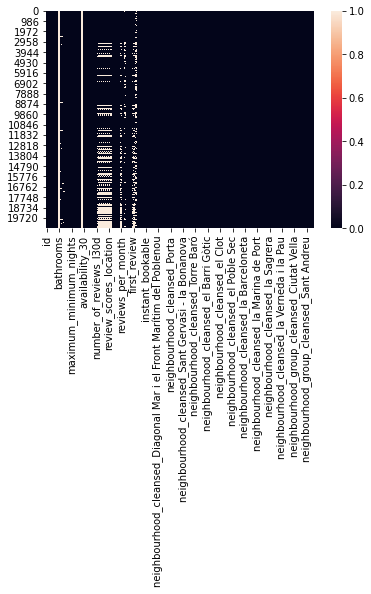

In [17]:
sns.heatmap(df_dict['aug'].isna())

In [18]:
for month in months:
    # we remove any column with more than a 20% of missing values
    df_dict[month].dropna(how='all', thresh = 0.80*df_dict[month].shape[0], axis = 1, inplace=True)
    # after that, only a few listings have missing values
    df_dict[month].dropna(axis=0, how='any', inplace=True)

In [19]:
df_dict['aug'].columns[df_dict['aug'].isna().sum()>0] # check that there isn't any NaN

Index([], dtype='object')

## Extra columns

In [20]:
for month in months:    
    # To solve the bed/accomm paradox, the number of occupants is the maximum of both    
    df_dict[month]['capacity'] = raw_df_dict[month].apply(lambda x: np.nanmax([x['beds'], x['accommodates']]), axis = 1)
    
    # We also are interested in the price per guest, as it might be more relevant
    df_dict[month]['price_person'] = df_dict[month]['price']/df_dict[month]['capacity']
    
    # We can distinguish between visited and non visted listings
    df_dict[month]['had_reviews']=raw_df_dict[month]['number_of_reviews_l30d'].apply(lambda x: 0 if x==0 else 1)


# Question 1: What was the impact of the pandemic on Airbnb accommodation from the second outbreak onwards?

Using the daily record of infections, we can measure the impact of the pandemic in different regions of Spain. We will compare the number of infections to the monthly number of reviews, which is highly correlated to the number of visitors. In doing so, we can do some inferences about the effect on tourism.

The daily record of Covid19 infections in every region of Spain can be found [here](https://cnecovid.isciii.es/covid19/#documentaci%C3%B3n-y-datos).

In [79]:
# Dates when each dataset was created
dates = {'aug': datetime.datetime(2020,8,1),
         'sep': datetime.datetime(2020,9,1),
         'oct': datetime.datetime(2020,10,1),
         'nov': datetime.datetime(2020,11,1),
         'dec': datetime.datetime(2020,12,1),
         'jan': datetime.datetime(2021,1,1),
         'feb': datetime.datetime(2021,2,1),
         'mar': datetime.datetime(2021,3,1),
         'apr': datetime.datetime(2021,4,1)
              }
date_series = pd.Series(data=dates)

In [80]:
# We load the Covid19 contagion data in Spain
cases_total = pd.read_csv('casos_tecnica_ccaa.csv') #covid cases in Spain
cases_total.set_index('ccaa_iso', inplace = True)
cases_cat = cases_total.loc['CT',['fecha','num_casos']] #covid cases in Catalonia
cases_cat['fecha'] = [datetime.datetime.strptime(date,"%Y-%m-%d" ) for date in cases_cat['fecha']]
cases_cat = cases_cat[(cases_cat['fecha']>=dates['aug']-datetime.timedelta(30))&(cases_cat['fecha']<=dates['apr'])] 

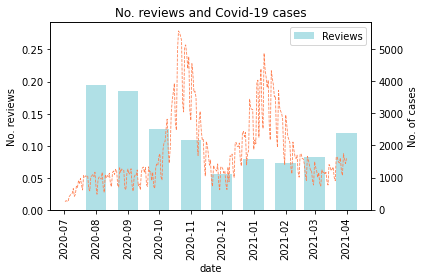

In [143]:
# List with the mean number of reviews of each month
mean_num_reviews = [df_dict[month]['number_of_reviews_l30d'].mean() for month in months]
y = mean_num_reviews

fig, ax1 = plt.subplots()
ax1.bar(date_series, mean_num_reviews, 
        ls='-', color = 'powderblue',
        width=20, label = 'Reviews')
ax1.set_xlabel('date')
ax1.set_ylabel('No. reviews')
ax1.set_title('No. reviews and Covid-19 cases')
ax1.xaxis.set_tick_params(rotation = 90) 
ax1.set_ylim(ymin=0, ymax=1.5*np.nanmax(y))

ax2 = ax1.twinx()
ax2.plot_date(cases_cat['fecha'], cases_cat['num_casos'], '--',
              xdate=True, linewidth=0.8, label='Covid', color='coral')
ax2.set_ylabel('No. of cases')
ax1.legend()

plt.tight_layout()
plt.savefig('q1.png', dpi=300)

By June 2020, the first wave started to decrease, leading to a peaceful summer. But in reality, summer 2020 was nothing but the eye of the storm, and by October, a fast second wave stroke in the region.

This second outbreak led to stricter traveling restrictions, which resulted in a decrease on the number of guests. By December 2020, prevalence declined to the level of the previous summer. However, this was not enough to convince travelers since the ease of restrictions took some time to appear. In addition, the uncertainty of the situation and the arrival of Christmas did not create the best scenario for traveling.
It comes as no surprise that Christmas celebrations meant a source of contagion, and a third wave took place. The number of visitors kept growing, though, and that trend continued until April 2021.


# Question 2: How did price evolved in these ever-changing circumstances?

Given the volatile situation, one might assume that hosts would adapt their strategy. Although they have little to take control of, an expectable response is to decrease the price of the listing to make it a better competitor against their neighbors.


In [29]:
visited_price = []
empty_price = []
for month in months:
    visited_price.append(df_dict[month].loc[df_dict[month]['number_of_reviews_l30d']>0,'price_person'].mean())
    empty_price.append(df_dict[month].loc[df_dict[month]['number_of_reviews_l30d']==0,'price_person'].mean())

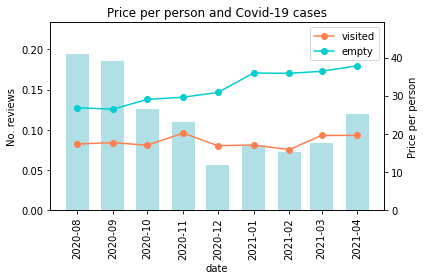

In [133]:
y = visited_price
fig, ax1 = plt.subplots()

ax1.set_xlabel('date')
ax1.set_title('Price per person and Covid-19 cases')
ax1.xaxis.set_tick_params(rotation = 90)
ax1.bar(date_series, mean_num_reviews, color = 'powderblue',
        width=20)
ax1.set_ylim(ymin=0, ymax=1.2*np.nanmax(mean_num_reviews))
ax1.set_ylabel('No. reviews')

ax2 = ax1.twinx()
ax2.plot_date(date_series, visited_price, 
              xdate=True, ls='-', color = 'coral',
              label = 'visited')
ax2.plot_date(date_series, empty_price, 
              xdate=True, ls='-', color = 'darkturquoise',
              label = 'empty')

ax2.set_ylim(ymin=0, ymax=1.3*np.nanmax(empty_price))
ax2.set_ylabel('Price per person')
ax2.legend(loc=1)


plt.tight_layout()
plt.savefig('q2.png', dpi=300)


Some differences can be found between non-visited and visited listings
1. Visited listings have a cheaper average price.
2. The average price of visited listings decreased after the autumn Covid19 wave.
3. The price of non-visited listings, instead, increased on average.


During highly restricted period, the preference towards lower prices decreased the mean price of visited listings.
    

# Question 3: Which are the key success factors to attract guests in this situation?
In other words, what can be done to keep afloat your Airbnb? 

In [33]:
df_dict['jan'].columns

Index(['id', 'host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'accommodates', 'bedrooms', 'beds', 'minimum_nights',
       'maximum_nights',
       ...
       'neighbourhood_group_cleansed_Horta-Guinardó',
       'neighbourhood_group_cleansed_Les Corts',
       'neighbourhood_group_cleansed_Nou Barris',
       'neighbourhood_group_cleansed_Sant Andreu',
       'neighbourhood_group_cleansed_Sant Martí',
       'neighbourhood_group_cleansed_Sants-Montjuïc',
       'neighbourhood_group_cleansed_Sarrià-Sant Gervasi', 'capacity',
       'price_person', 'had_reviews'],
      dtype='object', length=121)

In [145]:
df_comparison = df_dict['jan'].groupby('had_reviews').mean()
df_comparison.index.name = None
df_comparison = df_comparison.T
df_comparison['Relative difference'] = df_comparison.apply(lambda x: 100*(x[1]-x[0])/((x[0]+x[1])/2), axis = 1) 

In [30]:
df_comparison

,0,1,Relative difference
id,2.601403e+07,2.413415e+07,-7.497297
host_listings_count,1.769575e+01,1.380980e+01,-24.668363
host_total_listings_count,1.769575e+01,1.380980e+01,-24.668363
latitude,4.139226e+01,4.139098e+01,-0.003091
longitude,2.167298e+00,2.166563e+00,-0.033929
...,...,...,...
neighbourhood_group_cleansed_Sant Martí,1.025764e-01,9.334889e-02,-9.419437
neighbourhood_group_cleansed_Sants-Montjuïc,1.155486e-01,9.918320e-02,-15.242659
neighbourhood_group_cleansed_Sarrià-Sant Gervasi,4.510240e-02,5.017503e-02,10.648132
capacity,3.364663e+00,3.947491e+00,15.941362


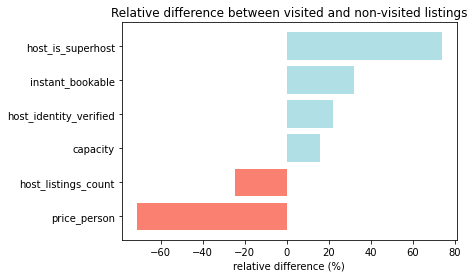

In [151]:
features = ['price_person', 'capacity', 'host_listings_count', 
            'host_is_superhost', 'instant_bookable', 'host_identity_verified']
plot_df = df_comparison.loc[features]
plot_df.sort_values(by='Relative difference', inplace=True)
colors = plot_df['Relative difference'].apply(lambda x: 'powderblue' if x>=0 else 'salmon')

fig, ax = plt.subplots()
ax.barh(plot_df.index, width=plot_df['Relative difference'], color=colors)
ax.set_title('Relative difference between visited and non-visited listings')
ax.set_xlabel('relative difference (%)')
plt.savefig('q3.png', dpi=400, bbox_inches='tight')

As expected, cheaper listings receive more visitors than expensive ones. This fact can be used in our favor to outsell the rest of competitors. But there is a point when the costs surpass the revenues, so this might not be an option in many cases
On the other hand, guests also show a preference for instant bookable listings. Therefore, enabling instant bookings might be a fast and easy option to increase the number of reservations. In addition, those listings whose host is superhost and has verified its identity seem to have earn trust from guests.
The owner of these listings usually have fewer listings, which means hotels are less appealing, arguably due to their higher price.